In [1]:
import kagglehub
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download latest version
data_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_path = os.path.join(data_path, 'chest_xray')

100%|██████████| 2.29G/2.29G [01:45<00:00, 23.5MB/s]

Extracting files...


In [34]:
import os
import random
import shutil
from math import ceil

def organize_dataset(original_dataset, new_dataset, split_ratios=(0.8, 0.1, 0.1)):
    """
    Combine, shuffle, and split dataset into train, val, and test sets.

    :param original_dataset: Path to the original dataset folder
    :param new_dataset: Path to the new dataset folder
    :param split_ratios: Tuple indicating the train, val, test split ratios
    """
    assert sum(split_ratios) == 1.0, "Split ratios must sum to 1.0"
    
    # Combine all data into a single list
    all_data = []
    class_names = os.listdir(os.path.join(original_dataset, 'train'))  # Assuming all sets have the same classes

    for class_name in class_names:
        for folder in ['train', 'val', 'test']:
            class_folder = os.path.join(original_dataset, folder, class_name)
            if os.path.exists(class_folder):
                images = [(os.path.join(class_folder, img), class_name) for img in os.listdir(class_folder)]
                all_data.extend(images)

    # Shuffle the combined data
    random.shuffle(all_data)

    # Calculate split sizes
    total_images = len(all_data)
    train_size = ceil(split_ratios[0] * total_images)
    val_size = ceil(split_ratios[1] * total_images)

    train_data = all_data[:train_size]
    val_data = all_data[train_size:train_size + val_size]
    test_data = all_data[train_size + val_size:]

    # Create new folder structure
    for split, split_data in zip(['train', 'val', 'test'], [train_data, val_data, test_data]):
        for img_path, class_name in split_data:
            split_class_dir = os.path.join(new_dataset, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(split_class_dir, os.path.basename(img_path)))

    print(f"Dataset organized successfully into {new_dataset}")
    print(f"Train: {len(train_data)} images, Val: {len(val_data)} images, Test: {len(test_data)} images")



In [35]:
new_dataset = "../chest_xray"
organize_dataset(data_path, new_dataset)

Dataset organized successfully into ../chest_xray
Train: 4685 images, Val: 586 images, Test: 585 images


In [10]:
import wandb
wandb.login()

wandb: Currently logged in as: vmazeeva (vmazeeva-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


True

In [6]:
os.environ["WANDB_SILENT"] = "true"

In [7]:
! git clone https://github.com/verammaz/MedImageClassXAI

Cloning into 'MedImageClassXAI'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 46 (delta 12), reused 44 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 46.28 KiB | 15.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [8]:
os.chdir('/content/MedImageClassXAI')

In [19]:
! python cnn.py -data_dir {data_path} -v -n_epochs 4

Number of classes    :  2
Shape of image       :  torch.Size([1, 256, 256])
Train batches        :  82
No. of train images  :  5216
No. of valid images  :  16
Labels               :  {'NORMAL': 0, 'PNEUMONIA': 1}
Image stats (mean, std):  tensor(0.5519) tensor(0.2131)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
       BatchNorm2d-6        [-1, 128, 128, 128]             256
              ReLU-7        [-1, 128, 128, 128]               0
         MaxPool2d-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 256, 64, 64]         295,168
      BatchNorm2d-10      

In [85]:
! python vit.py -data_dir {new_dataset} -n_epochs 1 -batch_size 16

python(21463) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device: cpu

Epoch 1
----------------------
Evaluate on Train dataset:   2%| | 6/293 [00:06<05:13,  1.09s/it, acc=69.7917%, ^C
Traceback (most recent call last):
  File "/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carnegie Mellon/CompMed/project/code/vit.py", line 344, in <module>
    main()
  File "/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carnegie Mellon/CompMed/project/code/vit.py", line 295, in main
    train_loss, train_acc, sens, spec = evaluate(model, train_dataloader, 'Train', criterion)
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carn

In [49]:
%matplotlib inline
%matplotlib notebook


In [53]:
! python gradcam.py -model_path '../models/SimpleCNN_lr0.001_img256_b16.pth' -model_type SimpleCNN -img_path '../chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg' -img_class 1

python(8361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/veramazeeva/Library/CloudStorage/OneDrive-Personal/Carnegie Mellon/CompMed/project/code/gradcam.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

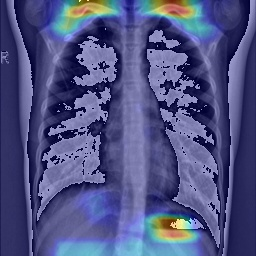

In [52]:
from IPython.display import Image, display
display(Image("gradcam_overlay.jpg"))

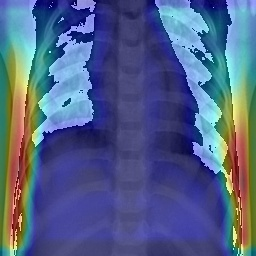

In [54]:
from IPython.display import Image, display
display(Image("gradcam_overlay.jpg"))